In [1]:
import numpy as np 
import os, sys, glob, csv
import pandas as pd
import time, datetime
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot  as plt 
import matplotlib as mpl
from astropy.table import Table,vstack,unique,Column
from astropy.time import Time
import pylab as py

def get_leginfo(misfile):
    
    leginfo =[]

    with open(misfile, 'r') as rf:
        for line_file in rf:
            if 'Takeoff:' in line_file:
                utc_date = line_file.split("Takeoff: ")[1].split(' ')[0]
            if ("Leg" in line_file) & ("Start" in line_file):
                st = line_file.split("Start: ")[1].split('Leg Dur:')[0]
                obj = line_file.split("(")[1].split(')')[0]
                dur = line_file.split('Leg Dur: ')[1].split(' Alt.:')[0]
                alt = line_file.split(' Alt.: ')[1].split('000 ft')[0]
                leginfo.append((pd.to_datetime(utc_date+' '+st.strip()),obj.strip(),dur.strip(),str(alt)))

        tms=[]
        for i in range(3,len(leginfo)-1):
            legnum=i
            x=leginfo[legnum][0]+pd.DateOffset(hours=-7)
            print(x, str(leginfo[legnum][1]))
            tms.append(x)

        ltags = [leginfo[i][1] for i in range(3,len(leginfo)-1)]
        ldurs = [leginfo[i][2] for i in range(3,len(leginfo)-1)]
        alts = [leginfo[i][3] for i in range(3,len(leginfo)-1)]

                
    return leginfo,tms,ltags,ldurs,alts


In [3]:
fp = '/Users/seftekh1/Desktop/my_corner/ADRstudy/'
path= '/Users/seftekh1/Desktop/HAWC_HQ/ObsOps/OC9Q/400Hz_sensor_data/'

mis = fp+'202205_HA_QUSAY_WX12.mis'
fnum,date = 886,'06-10-2022'

leginfo,tms,ltags,ldurs,alts = get_leginfo(mis)
print(ltags,ldurs)

2022-06-10 20:21:03 Setup
2022-06-10 20:56:02 HD 114576
2022-06-10 21:24:36 NGC4038
2022-06-10 22:21:36 L43
2022-06-10 23:30:31 G24_F1
2022-06-11 01:05:06 NGC4631
2022-06-11 02:59:00 PolarisFlare-1
2022-06-11 03:35:52 rno 1b
2022-06-11 04:26:07 Cage
['Setup', 'HD 114576', 'NGC4038', 'L43', 'G24_F1', 'NGC4631', 'PolarisFlare-1', 'rno 1b', 'Cage'] ['00:30:00', '00:28:00', '00:55:00', '01:08:00', '01:30:00', '01:52:00', '00:36:00', '00:50:00', '00:05:00']


### only run once per flight and then read the output 

In [4]:
# import datetime
# path= '/Users/seftekh1/Desktop/HAWC_HQ/ObsOps/OC9Q/400Hz_sensor_data/'

# fname = '886.csv'
# jt = pd.read_csv(path+fname, delimiter=',',
#                  names=['unixdatetime','nanosec','ta_ex','ta_xel','ta_los','si_el','si_xel','si_los'],skiprows=0)

# jt["timestamp"] = jt.apply(lambda row: datetime.datetime.fromtimestamp(row.unixdatetime) + \
#                            pd.Timedelta(row.nanosec, unit='ns'), axis=1)

# fp = '/Users/seftekh1/Desktop/my_corner/ADRstudy/'

# jt.to_csv(fp+'isotime_F'+fname, encoding='utf-8', index=False)

In [40]:
######## testing

# t = jt.unixdatetime[0]

# value = datetime.datetime.fromtimestamp(t)
# nano = jt.nanosec[0]
# value + pd.Timedelta(nano, unit='ns')

# jt["timestamp"] = jt.apply(lambda row: datetime.datetime.fromtimestamp(row.unixdatetime) + \
#                            pd.Timedelta(row.nanosec, unit='ns'), axis=1)



In [44]:
jt.columns

Index(['unixdatetime', 'nanosec', 'ta_ex', 'ta_xel', 'ta_los', 'si_el',
       'si_xel', 'si_los', 'timestamp'],
      dtype='object')

### reading in mrf files and combining them 

In [5]:
fp = '/Users/seftekh1/Desktop/my_corner/ADRstudy/'
hkpath = '/Users/seftekh1/Desktop/my_corner/ADRstudy/hk/EndOfSeries/'
mrf1 = hkpath+ '220609_LHe_Flight886-mrf.tsv'

# 
hk =  pd.read_csv(mrf1, delim_whitespace=True,
                      names=['DATA','col','Time_sec','Temp_K','Resistence',
                             'Voltage','Current','mmddyyyy','hhmmss'])

timedelta = pd.Timedelta(0,unit= 'm')
hk['time_str'] = hk.apply(lambda x: x['mmddyyyy']+' '+x['hhmmss'],axis=1)
hk['timestamp'] = pd.to_datetime(hk['time_str'])-timedelta
# hk['timestamp'] = hk['timestamp'].dt.tz_localize('US/pacific').dt.tz_convert('utc')
#nhk = hk.set_index('timestamp')

nhk= hk.set_index('timestamp')
nhk = nhk.resample("20s").mean()
nhk["C_120"] = nhk["Current"].shift(6)

nhk["AmpHour"] = 3600*(nhk["Current"] - nhk["C_120"])/120

print(len(hk.time_str.values),hk.timestamp.values[0],(hk.timestamp.values[-1]),len(hk.timestamp.values))
hk.info(),nhk.info()



2125 2022-06-10T18:20:46.000000000 2022-06-11T04:39:36.000000000 2125
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125 entries, 0 to 2124
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATA        2125 non-null   object        
 1   col         2125 non-null   object        
 2   Time_sec    2125 non-null   float64       
 3   Temp_K      2125 non-null   float64       
 4   Resistence  2125 non-null   float64       
 5   Voltage     2125 non-null   float64       
 6   Current     2125 non-null   float64       
 7   mmddyyyy    2125 non-null   object        
 8   hhmmss      2125 non-null   object        
 9   time_str    2125 non-null   object        
 10  timestamp   2125 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 182.7+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1857 entries, 2022-06-10 18:20:40 to 2022-06-11 04:39:20
Freq: 20S
Data c

(None, None)

### Reading in 400hz data and resampling 

In [6]:
df = pd.read_csv(fp+'isotime_F886.csv',skiprows=1,
                      names=['unixdatetime', 'nanosec', 'ta_ex', 'ta_xel', 'ta_los', 'si_el',
     'si_xel', 'si_los', 'timestamp'],parse_dates=[8])


In [7]:
ndf = df.set_index('timestamp')
per17sec = pd.DataFrame()

per17sec['si_el'] = ndf.si_el.resample('17s').mean()
per17sec['si_xel'] = ndf.si_xel.resample('17s').mean()
per17sec['si_los'] = ndf.si_los.resample('17s').mean()


### Reading in 50Hz data and resampling 

In [9]:
fp50 = '/Users/seftekh1/Desktop/my_corner/ADRstudy/50hz_sensordata_OC9Q/'
f50name = 'ta_tsc_tsc_mcs_hk_F'+str(fnum)+'.csv'

df5 = pd.read_csv(fp50+f50name, delimiter=',',
             names=['unixdatetime','nanosec','atc_el','atc_xel','atc_los'],skiprows=1)
df5.unixdatetime = pd.to_datetime(df5.unixdatetime)-pd.DateOffset(hours=7)  ### UTC to Local PT
df5.rename(columns = {'unixdatetime':'timestamp'}, inplace = True)

ndf5 = df5.set_index('timestamp')

df5p17 = pd.DataFrame()#ndf5[['timestamp','atc_el','atc_xel','atc_los']]


df5p17['atc_el'] = ndf5.atc_el.resample('17s').mean()
df5p17['atc_xel'] = ndf5.atc_xel.resample('17s').mean()
df5p17['atc_los'] = ndf5.atc_los.resample('17s').mean()

df5p17.reset_index(inplace=True)


ndf5.info(), df5p17.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1062162 entries, 2022-06-10 16:00:05.723000 to 2022-06-11 05:01:43.807000
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   nanosec  1062162 non-null  float64
 1   atc_el   1062162 non-null  float64
 2   atc_xel  1062162 non-null  float64
 3   atc_los  1062162 non-null  float64
dtypes: float64(4)
memory usage: 40.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2760 non-null   datetime64[ns]
 1   atc_el     2760 non-null   float64       
 2   atc_xel    2760 non-null   float64       
 3   atc_los    2760 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 86.4 KB


(None, None)

### Joing hk and 400Hz data frames and treating the NaNs

In [10]:
df_join = df5p17.set_index("timestamp").join(per17sec, how="outer")
df_join = df_join.join(nhk, how="outer")

# df_join = df_join.resample("17s").mean()

df_join.head()

,atc_el,atc_xel,atc_los,si_el,si_xel,si_los,Time_sec,Temp_K,Resistence,Voltage,Current,C_120,AmpHour
timestamp,,,,,,,,,,,,,
2022-06-10 15:59:56,0.000021,-0.000011,0.000041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-10 16:00:13,-0.000044,-0.000019,0.000072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-10 16:00:30,-0.000023,-0.000009,0.000117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-10 16:00:47,-0.000043,-0.000014,0.000097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-10 16:01:04,-0.000024,-0.000003,0.000043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# columns to be filled
cols = df_join.columns #["atc_el", "atc_xel", "atc_los", "si_el", "si_xel", "si_los"]

df_filled = df_join[cols].interpolate(method='linear', limit_direction='forward', axis=0)

# adding other columns back in the df_filled
for col in df_join.columns:
    if col not in cols:
        df_filled[col] = df_join[col]

df_filled.tail(10)

,atc_el,atc_xel,atc_los,si_el,si_xel,si_los,Time_sec,Temp_K,Resistence,Voltage,Current,C_120,AmpHour
timestamp,,,,,,,,,,,,,
2022-06-11 05:13:33,-0.000008,-0.001413,0.001118,0.052301,7.487927,-6.305141,63534.995,0.169939,81473.0,-0.00177,0.322955,0.331676,-0.261633
2022-06-11 05:13:50,-0.000008,-0.001413,0.001118,0.028668,7.484012,-6.309244,63534.995,0.169939,81473.0,-0.00177,0.322955,0.331676,-0.261633
2022-06-11 05:14:07,-0.000008,-0.001413,0.001118,-0.050498,7.483832,-6.310550,63534.995,0.169939,81473.0,-0.00177,0.322955,0.331676,-0.261633
2022-06-11 05:14:24,-0.000008,-0.001413,0.001118,-0.047280,7.483305,-6.310303,63534.995,0.169939,81473.0,-0.00177,0.322955,0.331676,-0.261633
2022-06-11 05:14:41,-0.000008,-0.001413,0.001118,-0.047586,7.483442,-6.310475,63534.995,0.169939,81473.0,-0.00177,0.322955,0.331676,-0.261633
2022-06-11 05:14:58,-0.000008,-0.001413,0.001118,-0.047647,7.483224,-6.310467,63534.995,0.169939,81473.0,-0.00177,0.322955,0.331676,-0.261633
2022-06-11 05:15:15,-0.000008,-0.001413,0.001118,-0.047805,7.483173,-6.310412,63534.995,0.169939,81473.0,-0.00177,0.322955,0.331676,-0.261633
2022-06-11 05:15:32,-0.000008,-0.001413,0.001118,-0.047806,7.483183,-6.310391,63534.995,0.169939,81473.0,-0.00177,0.322955,0.331676,-0.261633
2022-06-11 05:15:49,-0.000008,-0.001413,0.001118,-0.047862,7.483216,-6.310460,63534.995,0.169939,81473.0,-0.00177,0.322955,0.331676,-0.261633


### correlations for a leg

<AxesSubplot:>

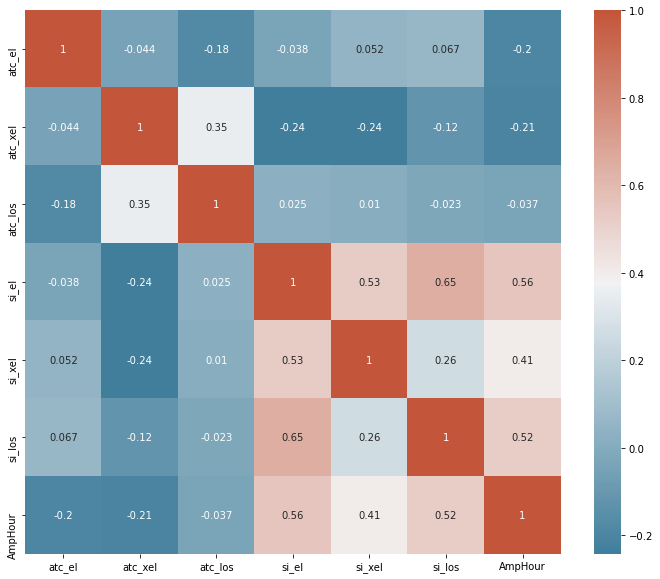

In [12]:

import seaborn as sns
data = df_filled.loc[tms[1]:tms[2]]
N = len(data)
data = data.iloc[int(0.15*N):int(0.85*N)]

cols = ['atc_el', 'atc_xel', 'atc_los', 'si_el', 'si_xel', 'si_los', 'AmpHour']
datac = data[cols]
corr = datac.corr()

#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = None, cmap=cmap)



In [13]:
data.columns

Index(['atc_el', 'atc_xel', 'atc_los', 'si_el', 'si_xel', 'si_los', 'Time_sec',
       'Temp_K', 'Resistence', 'Voltage', 'Current', 'C_120', 'AmpHour'],
      dtype='object')

Text(0, 0.5, 'F885_si_xel')

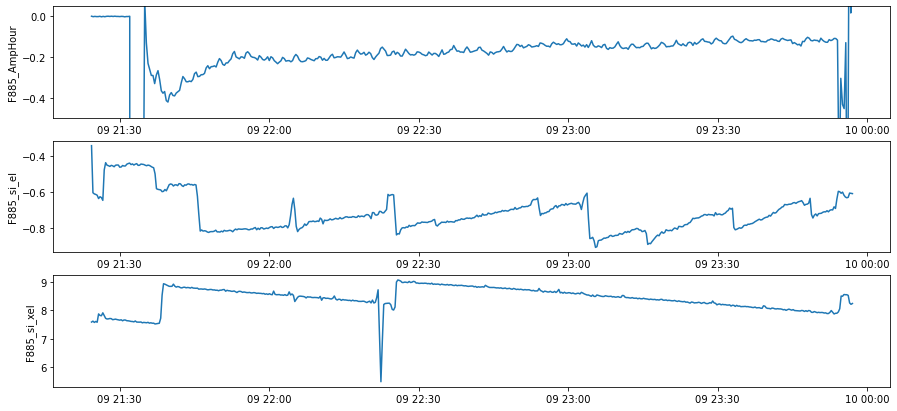

In [14]:
leg = 1

data = df_filled.loc[tms[leg]:tms[leg+1]]

N = len(data)
data = data.iloc[int(0.15*N):int(0.85*N)]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))

ax1.plot(nhk.loc[tms[leg]:tms[leg+3]].AmpHour)
ax1.set_ylim(-0.5,0.05)
ax1.set_ylabel('F'+str(fnum)+"_AmpHour")

ax2.plot(per17sec.loc[tms[leg]:tms[leg+3]].si_el)
ax2.set_ylabel('F'+str(fnum)+"_si_el")

ax3.plot(per17sec.loc[tms[leg]:tms[leg+3]].si_xel)
ax3.set_ylabel('F'+str(fnum)+"_si_xel")


### working with ADR rate fluctuations ->  a rolling average 

<ipython-input-14-3e11f05eaaac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["AmpHour_avg"] = data.AmpHour.rolling(window=70, center=True).mean()


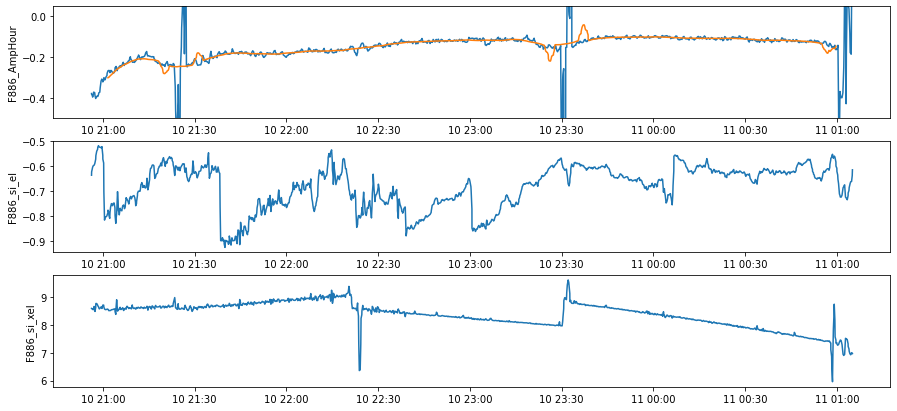

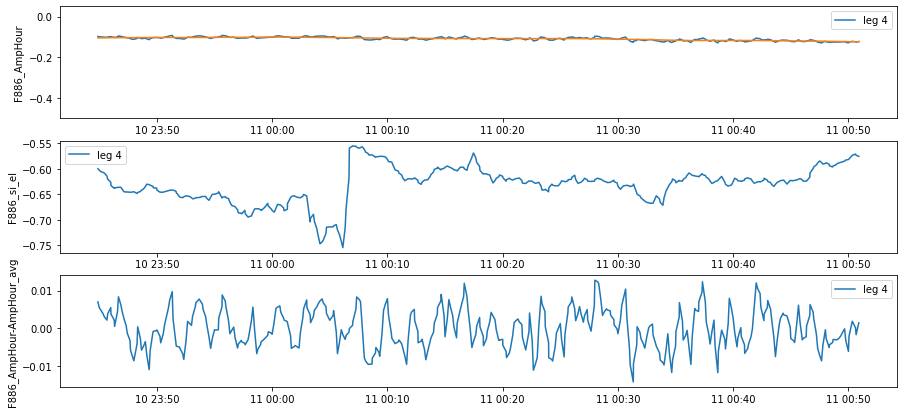

In [14]:
leg = 1

data = df_filled.loc[tms[leg]:tms[leg+4]]
data["AmpHour_avg"] = data.AmpHour.rolling(window=70, center=True).mean()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))

ax1.plot(data.AmpHour)
ax1.set_ylim(-0.5,0.05)
ax1.set_ylabel('F'+str(fnum)+"_AmpHour")
ax1.plot(data["AmpHour_avg"])

ax2.plot(data.si_el)
ax2.set_ylabel('F'+str(fnum)+"_si_el")

ax3.plot(data.si_xel)
ax3.set_ylabel('F'+str(fnum)+"_si_xel")


############# single leg

# single leg 
leg = 4
leg_data = data.loc[tms[leg]:tms[leg+1]]
N = len(leg_data)
leg_data = leg_data.iloc[int(0.15*N):int(0.85*N)]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))

ax1.plot(leg_data.AmpHour, label='leg '+str(leg))
ax1.set_ylim(-0.5,0.05)
ax1.set_ylabel('F'+str(fnum)+"_AmpHour")
ax1.plot(leg_data["AmpHour_avg"])
ax1.legend()

ax2.plot(leg_data.si_el, label='leg '+str(leg))
ax2.set_ylabel('F'+str(fnum)+"_si_el")
ax2.legend()

ax3.plot(leg_data.AmpHour-leg_data.AmpHour_avg, label='leg '+str(leg))
ax3.set_ylabel('F'+str(fnum)+"_AmpHour-AmpHour_avg")
ax3.legend()


In [15]:
# single leg 
def get_leg_data_corr(df_filled, tms, start, end, window=50):
    
    data = df_filled#.loc[tms[start]:tms[end]]
    data["AmpHour_avg"] = data.AmpHour.rolling(window=window, center=True).mean()

    leg_dict = {}

    for leg in range(start, end):

        leg_data = data.loc[tms[leg]:tms[leg+1]]
        N = len(leg_data)
        leg_data = leg_data.iloc[int(0.15*N):int(0.85*N)]

        leg_dict[leg] = leg_data

    all_leg_data = pd.concat([leg_data for leg, leg_data in leg_dict.items()])
    all_leg_data["AmpHourFluc"] = all_leg_data.AmpHour-all_leg_data.AmpHour_avg
    
    corr = all_leg_data[["AmpHourFluc", "si_el", "si_xel", "si_los", "atc_el", "atc_xel", "atc_los"]].corr()
    correlation = corr.loc["AmpHourFluc"].iloc[1:].to_dict()
    
    return correlation

<ipython-input-16-89f25fe0b040>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fp+'corr_F{}-{}.png'.format(fnum,date),tight_layout=True)


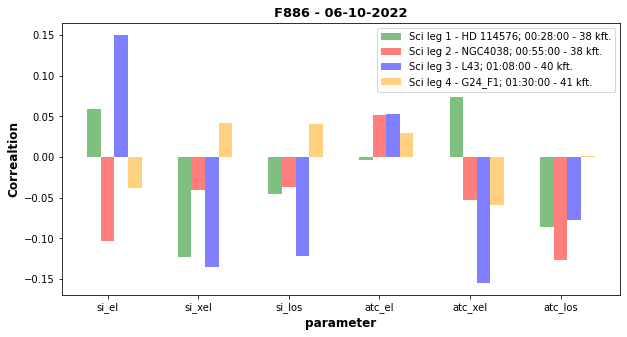

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

barWidth = 0.15

legs = [1, 2, 3, 4]
pallette = ["green", "red", "blue", "orange", "magenta", "purple"]
bar = np.arange(6)

for i, l in enumerate(legs):
    
    Corr = get_leg_data_corr(df_filled, tms, l, l+1, window=70) 
    ax.bar(bar, Corr.values(), color = pallette[i], width = barWidth, label="Sci leg {} - {}; {} - {} kft.".format(l,ltags[l],ldurs[l],alts[l]), alpha=0.5)
    bar = [x + barWidth for x in bar]


# Adding Xticks
ax.set_title('F{} - {}'.format(fnum,date), fontweight ='bold', fontsize = 13)
ax.set_xlabel('parameter', fontweight ='bold', fontsize = 12)
ax.set_ylabel('Correaltion', fontweight ='bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(Corr))], Corr.keys()) 
ax.legend()

plt.savefig(fp+'corr_F{}-{}.png'.format(fnum,date),tight_layout=True)